In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)   

data = pd.read_csv('DATA_KOTA.csv')
data_kecelakaan = data['jumlah_kecelakaan']

df = pd.DataFrame(data)

# Membagi kolom tanggal menjadi tahun dan bulan
df['tahun'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[0]))
df['bulan'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[1]))

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Memisahkan fitur dan target
X = df[['tahun', 'bulan']].values
y = df['jumlah_kecelakaan'].values

In [3]:
# Pisahkan data menjadi training dan testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [4]:
# Fungsi untuk menghitung MAPE menggunakan model SVR dengan parameter tertentu
def calculate_mape(X_train, y_train, X_val, y_val, params):
    C, epsilon, gamma = params
    svr = SVR(kernel='linear', C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred) * 100
    return mape

# Inisialisasi populasi awal
def initialize_population(population_size, parameter_ranges):
    population = []
    for _ in range(population_size):
        chromosome = []
        for param_range in parameter_ranges:
            param_value = np.random.uniform(param_range[0], param_range[1])
            chromosome.append(param_value)
        population.append(chromosome)
    return population

# Seleksi individu berdasarkan nilai fitness (MAPE)
def selection(population, X_train, y_train, X_val, y_val):
    selected_population = []
    for chromosome in population:
        mape = calculate_mape(X_train, y_train, X_val, y_val, chromosome)
        selected_population.append((chromosome, mape))
    selected_population.sort(key=lambda x: x[1])  # Sort berdasarkan MAPE terendah
    return selected_population[:len(population)//2]  # Pilih setengah individu terbaik

# Crossover: Menghasilkan keturunan dari pasangan individu terpilih
def crossover(selected_population):
    new_population = []
    ukuran_populasi = len(selected_population)
    
    for i in range(ukuran_populasi):
        parent1 = selected_population[i][0]
        
        # Tentukan parent2 dengan pemeriksaan batas
        if i % 2 == 0:
            if i - 1 >= 0:
                parent2 = selected_population[i-1][0]
            else:
                parent2 = selected_population[i][0]  # Penanganan alternatif jika i-1 tidak valid
        else:
            if i + 1 < ukuran_populasi:
                parent2 = selected_population[i+1][0]
            else:
                parent2 = selected_population[i][0]  # Penanganan alternatif jika i+1 tidak valid
        
        crossover_point = np.random.randint(1, len(parent1)-1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        new_population.append(child)
    
    return new_population

# Mutasi: Mengubah nilai gen secara acak pada populasi baru
def mutation(new_population, mutation_rate, parameter_ranges):
    for i in range(len(new_population)):
        if np.random.random() < mutation_rate:
            mutated_gene_index = np.random.randint(0, len(new_population[i]))
            new_value = np.random.uniform(parameter_ranges[mutated_gene_index][0], parameter_ranges[mutated_gene_index][1])
            new_population[i][mutated_gene_index] = new_value
    return new_population

In [5]:
population_size = 50
parameter_ranges = [(0.0001, 50), (1e-07, 5), (1e-07, 5)]
results_generations = []

# Konfigurasi eksperimen
crossover_rate = 0.5  # Tetapkan tingkat crossover tetap untuk eksperimen
mutation_rate = 0.2  # Tetapkan tingkat mutasi tetap untuk eksperimen
num_generations = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 500, 1000]

# Mencari jumlah generasi optimal
best_num_generations = None
best_mape_generations = float('inf')

for num_gen in num_generations:
    population = initialize_population(population_size, parameter_ranges)

    for generation in range(num_gen):
        selected_population = selection(population, X_train, y_train, X_val, y_val)
        new_population = crossover(selected_population)
        new_population = mutation(new_population, mutation_rate, parameter_ranges)

        # Adjust the population size if necessary
        if len(new_population) < population_size:
            additional_individuals = initialize_population(population_size - len(new_population), parameter_ranges)
            new_population.extend(additional_individuals)
        elif len(new_population) > population_size:
            new_population = new_population[:population_size]

        # Make sure the new population has the correct size
        assert len(new_population) == population_size, "Ukuran populasi baru tidak sesuai"

        population = new_population

    # Mengambil individu terbaik (dengan MAPE terendah) dari populasi terakhir
    best_chromosome, best_population_mape = min(selected_population, key=lambda x: x[1])
    results_generations.append((num_gen, best_population_mape))

    print(f"MAPE terbaik untuk {num_gen} generasi: {best_population_mape}")

    if best_population_mape < best_mape_generations:
        best_mape_generations = best_population_mape
        best_num_generations = num_gen

print(f"\nJumlah generasi optimal: {best_num_generations}")
print(f"MAPE terbaik: {best_mape_generations}")

MAPE terbaik untuk 25 generasi: 23.942232802683126
MAPE terbaik untuk 50 generasi: 25.422267293541
MAPE terbaik untuk 75 generasi: 25.409303426014716
MAPE terbaik untuk 100 generasi: 24.026894449404836
MAPE terbaik untuk 125 generasi: 25.49603582217937
MAPE terbaik untuk 150 generasi: 24.94046478815413
MAPE terbaik untuk 175 generasi: 24.888733039733804
MAPE terbaik untuk 200 generasi: 24.2660339048282
MAPE terbaik untuk 225 generasi: 25.534551270160616
MAPE terbaik untuk 250 generasi: 24.50766106026627
MAPE terbaik untuk 500 generasi: 24.841324307859868
MAPE terbaik untuk 1000 generasi: 24.73249892035836

Jumlah generasi optimal: 25
MAPE terbaik: 23.942232802683126


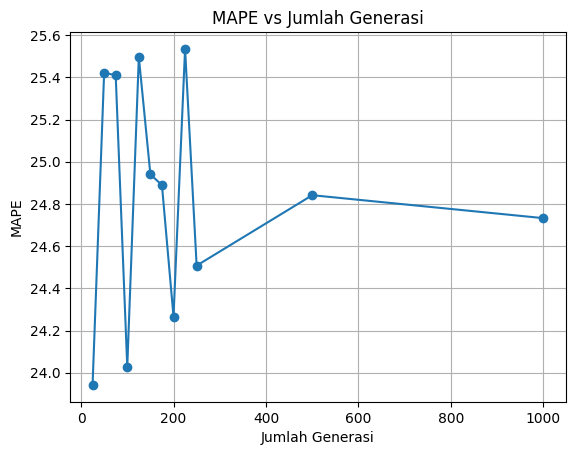

In [7]:
# Plot hasil setiap iterasi dan nilai MAPE-nya
num_gen, best_mape_generations = zip(*results_generations)
plt.plot(num_gen, best_mape_generations, marker='o')
plt.xlabel("Jumlah Generasi")
plt.ylabel("MAPE")
plt.title("MAPE vs Jumlah Generasi")
plt.grid(True)
plt.show()